In [1]:
# Import
import numpy as np
import pandas as pd
import sys
from datetime import datetime
sys.path.append('../..')
import pickle

import h5py
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, MaxPooling2D, Conv2D
from keras.callbacks import ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import missingno as msno

from Classifier.data_processing import processor
#from Classifier.prediction_model import Neural_Net, DNN, LSTM

Using TensorFlow backend.


In [2]:
with open('pickles/core_data.pickle', 'rb') as f:
            data = pickle.load(f)

In [3]:
# Change into update function
start_time = datetime(2016,1,1)
end_time = datetime(2018,2,25)
interval = 1440 # 1440 minutes = 1 day

data = processor.historical_download(start_time, end_time, interval)
#data.append(update)

with open('pickles/core_data.pickle', 'wb') as f:
            pickle.dump(data, f)

No Reddit pickle found


In [ ]:
start_time_n = datetime(2018,2,21)
end_time_n = datetime(2018,3,16)
interval = 1440
new_data = processor.historical_download(start_time_n, end_time_n, interval, load_pickle=False)

time period from 2018-02-21 07:27:17.711861 to 1519203980.2045777
time period from 2018-02-21 16:06:20.204578 to 1519231872.5373385
time period from 2018-02-21 23:51:12.537338 to 1519262201.9305832
time period from 2018-02-22 08:16:41.930583 to 1519293886.9984891
time period from 2018-02-22 17:04:46.998489 to 1519321695.7361417
time period from 2018-02-23 00:48:15.736142 to 1519349902.352191
time period from 2018-02-23 08:38:22.352191 to 1519379991.954594
time period from 2018-02-23 16:59:51.954594 to 1519412099.3047109
time period from 2018-02-24 01:54:59.304711 to 1519443531.205142
time period from 2018-02-24 10:38:51.205142 to 1519473612.2037313
time period from 2018-02-24 19:00:12.203731 to 1519503696.579035
time period from 2018-02-25 03:21:36.579035 to 1519538676.0887885
time period from 2018-02-25 13:04:36.088789 to 1519571224.332733
time period from 2018-02-25 22:07:04.332733 to 1519606910.0325935
time period from 2018-02-26 08:01:50.032593 to 1519643598.148346
call rate limite

## Data preparation and scrubbing

In [3]:
"""
Data visualisation to understand where missing data and null values are
"""

%matplotlib inline
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(data.head(1))
#x = msno.matrix(data)

#data.isnull().sum()

In [4]:
"""
Scrub non-viable data
"""

def scrub(data):
    data.drop('Ltc_search_US', axis=1, inplace=True)
    data.drop('Ltc_search_GB', axis=1, inplace=True)
    data.drop('Ltc_search_FR', axis=1, inplace=True)
    data.drop('Ltc_search_DE', axis=1, inplace=True)
    data.drop('Ltc_search_RU', axis=1, inplace=True)
    data.drop('Ltc_search_KR', axis=1, inplace=True)
    data.drop('Eth_search_US', axis=1, inplace=True)
    data.drop('Eth_search_GB', axis=1, inplace=True)
    data.drop('Eth_search_FR', axis=1, inplace=True)
    data.drop('Eth_search_DE', axis=1, inplace=True)
    data.drop('Eth_search_RU', axis=1, inplace=True)
    data.drop('Eth_search_KR', axis=1, inplace=True)
    data.drop('Btc_search_US', axis=1, inplace=True)
    data.drop('Btc_search_GB', axis=1, inplace=True)
    data.drop('Btc_search_FR', axis=1, inplace=True)
    data.drop('Btc_search_DE', axis=1, inplace=True)
    data.drop('Btc_search_RU', axis=1, inplace=True)
    data.drop('Btc_search_KR', axis=1, inplace=True)
    data.drop('Etheur_gdax_low', axis=1, inplace=True)
    data.drop('Etheur_gdax_high', axis=1, inplace=True)
    data.drop('Etheur_gdax_open', axis=1, inplace=True)
    data.drop('Etheur_gdax_close', axis=1, inplace=True)
    data.drop('Etheur_gdax_vol', axis=1, inplace=True)
    data.drop('Ltcusd_gdax_low', axis=1, inplace=True)
    data.drop('Ltcusd_gdax_high', axis=1, inplace=True)
    data.drop('Ltcusd_gdax_open', axis=1, inplace=True)
    data.drop('Ltcusd_gdax_close', axis=1, inplace=True)
    data.drop('Ltcusd_gdax_vol', axis=1, inplace=True)
    data.drop('Ltceur_gdax_low', axis=1, inplace=True)
    data.drop('Ltceur_gdax_high', axis=1, inplace=True)
    data.drop('Ltceur_gdax_open', axis=1, inplace=True)
    data.drop('Ltceur_gdax_close', axis=1, inplace=True)
    data.drop('Ltceur_gdax_vol', axis=1, inplace=True)


    #data.drop('Ethusd_kraken_close', axis=1, inplace=True)
    #data.drop('Btceur_kraken_open', axis=1, inplace=True)
    data = data.astype('float64')
    data = data.interpolate()
    return data

In [5]:
"""
Split data into training set and targets
"""

target = "Btcusd_kraken_close"
forecast_range = 1
x, y, actuals = processor.generate_x_y(data, target=target, forecast_range=1)

In [6]:
"""
Convert to float and normalise data
"""

x = (x - x.mean(axis=0)) / x.std(axis=0)
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

In [7]:
"""
Split data into training vs validation sets
"""
train_x, valid_x = x[:-30], x[-30:]
train_y, valid_y = y[:-30], y[-30:]
actuals = actuals[-30:]
#actuals_shifted = actuals.shift(-forecast_range) # Shifting for future plotting against predictions

## Prediction using standard MLP

In [8]:
# Define neural network

class DNN:
    """
    Standard fully connected MLP as baseline
    """
    def __init__(self, input_size, learning_rate, activation='relu'):
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.activation = activation
        self.build_model()

    def build_model(self):
        self.model = Sequential()
        self.model.add(Dense(32, activation = self.activation, input_dim = self.input_size))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(64, activation = self.activation))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(128, activation = self.activation))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(units=1, activation='linear'))

        # Define optimiser and compile
        optimizer = optimizers.Adam(self.learning_rate)
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

In [9]:
# Initialise weight saving callback
DNN_checkpointer = ModelCheckpoint(filepath='./saved_models/DNN_weights.hdf5',
                       verbose=1, save_best_only=True)

In [10]:
# Initialise training hyper parameters
learning_rate = 0.0001
input_size = train_x.shape[1]
epochs = 500
batch_size = 64

# Initialise neural network
Deep_net = DNN(input_size, learning_rate)

# Start training
Deep_net.model.fit(train_x, train_y,
               batch_size=batch_size, epochs=epochs,
               callbacks=[DNN_checkpointer],
               validation_data=(valid_x, valid_y))


Train on 640 samples, validate on 30 samples
Epoch 1/500
640/640 [==============================] - 1s 1ms/step - loss: 1.6234 - acc: 0.0000e+00 - val_loss: 3.5669 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 3.56689, saving model to ./saved_models/DNN_weights.hdf5
Epoch 2/500
640/640 [==============================] - 0s 42us/step - loss: 1.3712 - acc: 0.0000e+00 - val_loss: 3.3234 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 3.56689 to 3.32344, saving model to ./saved_models/DNN_weights.hdf5
Epoch 3/500
640/640 [==============================] - 0s 45us/step - loss: 1.2955 - acc: 0.0000e+00 - val_loss: 3.1213 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 3.32344 to 3.12125, saving model to ./saved_models/DNN_weights.hdf5
Epoch 4/500
640/640 [==============================] - 0s 44us/step - loss: 1.1290 - acc: 0.0000e+00 - val_loss: 2.9642 - val_acc: 0.0000e+00

Epoch 00004: val_loss improved from 3.12125 to 2.96417, saving model to ./sa

Epoch 34/500
640/640 [==============================] - 0s 45us/step - loss: 0.5201 - acc: 0.0000e+00 - val_loss: 1.3885 - val_acc: 0.0000e+00

Epoch 00034: val_loss improved from 1.40046 to 1.38853, saving model to ./saved_models/DNN_weights.hdf5
Epoch 35/500
640/640 [==============================] - 0s 50us/step - loss: 0.5819 - acc: 0.0000e+00 - val_loss: 1.3766 - val_acc: 0.0000e+00

Epoch 00035: val_loss improved from 1.38853 to 1.37662, saving model to ./saved_models/DNN_weights.hdf5
Epoch 36/500
640/640 [==============================] - 0s 48us/step - loss: 0.5369 - acc: 0.0000e+00 - val_loss: 1.3725 - val_acc: 0.0000e+00

Epoch 00036: val_loss improved from 1.37662 to 1.37250, saving model to ./saved_models/DNN_weights.hdf5
Epoch 37/500
640/640 [==============================] - 0s 52us/step - loss: 0.5890 - acc: 0.0000e+00 - val_loss: 1.3582 - val_acc: 0.0000e+00

Epoch 00037: val_loss improved from 1.37250 to 1.35820, saving model to ./saved_models/DNN_weights.hdf5
Epoch 38

640/640 [==============================] - 0s 45us/step - loss: 0.4861 - acc: 0.0000e+00 - val_loss: 1.2182 - val_acc: 0.0000e+00

Epoch 00068: val_loss improved from 1.21969 to 1.21822, saving model to ./saved_models/DNN_weights.hdf5
Epoch 69/500
640/640 [==============================] - 0s 51us/step - loss: 0.4827 - acc: 0.0000e+00 - val_loss: 1.2145 - val_acc: 0.0000e+00

Epoch 00069: val_loss improved from 1.21822 to 1.21447, saving model to ./saved_models/DNN_weights.hdf5
Epoch 70/500
640/640 [==============================] - 0s 48us/step - loss: 0.4913 - acc: 0.0000e+00 - val_loss: 1.2118 - val_acc: 0.0000e+00

Epoch 00070: val_loss improved from 1.21447 to 1.21184, saving model to ./saved_models/DNN_weights.hdf5
Epoch 71/500
640/640 [==============================] - 0s 48us/step - loss: 0.4610 - acc: 0.0000e+00 - val_loss: 1.2115 - val_acc: 0.0000e+00

Epoch 00071: val_loss improved from 1.21184 to 1.21155, saving model to ./saved_models/DNN_weights.hdf5
Epoch 72/500
640/640 


Epoch 00106: val_loss did not improve
Epoch 107/500
640/640 [==============================] - 0s 45us/step - loss: 0.4062 - acc: 0.0000e+00 - val_loss: 1.1758 - val_acc: 0.0000e+00

Epoch 00107: val_loss did not improve
Epoch 108/500
640/640 [==============================] - 0s 50us/step - loss: 0.3827 - acc: 0.0000e+00 - val_loss: 1.1796 - val_acc: 0.0000e+00

Epoch 00108: val_loss did not improve
Epoch 109/500
640/640 [==============================] - 0s 49us/step - loss: 0.3980 - acc: 0.0000e+00 - val_loss: 1.1797 - val_acc: 0.0000e+00

Epoch 00109: val_loss did not improve
Epoch 110/500
640/640 [==============================] - 0s 47us/step - loss: 0.4131 - acc: 0.0000e+00 - val_loss: 1.1785 - val_acc: 0.0000e+00

Epoch 00110: val_loss did not improve
Epoch 111/500
640/640 [==============================] - 0s 44us/step - loss: 0.3674 - acc: 0.0000e+00 - val_loss: 1.1752 - val_acc: 0.0000e+00

Epoch 00111: val_loss did not improve
Epoch 112/500
640/640 [=======================

640/640 [==============================] - 0s 41us/step - loss: 0.3293 - acc: 0.0000e+00 - val_loss: 1.1767 - val_acc: 0.0000e+00

Epoch 00149: val_loss did not improve
Epoch 150/500
640/640 [==============================] - 0s 47us/step - loss: 0.3655 - acc: 0.0000e+00 - val_loss: 1.1762 - val_acc: 0.0000e+00

Epoch 00150: val_loss did not improve
Epoch 151/500
640/640 [==============================] - 0s 50us/step - loss: 0.3131 - acc: 0.0000e+00 - val_loss: 1.1791 - val_acc: 0.0000e+00

Epoch 00151: val_loss did not improve
Epoch 152/500
640/640 [==============================] - 0s 49us/step - loss: 0.3197 - acc: 0.0000e+00 - val_loss: 1.1807 - val_acc: 0.0000e+00

Epoch 00152: val_loss did not improve
Epoch 153/500
640/640 [==============================] - 0s 46us/step - loss: 0.3665 - acc: 0.0000e+00 - val_loss: 1.1808 - val_acc: 0.0000e+00

Epoch 00153: val_loss did not improve
Epoch 154/500
640/640 [==============================] - 0s 48us/step - loss: 0.3477 - acc: 0.0000e

640/640 [==============================] - 0s 50us/step - loss: 0.3045 - acc: 0.0000e+00 - val_loss: 1.1737 - val_acc: 0.0000e+00

Epoch 00194: val_loss did not improve
Epoch 195/500
640/640 [==============================] - 0s 50us/step - loss: 0.3107 - acc: 0.0000e+00 - val_loss: 1.1748 - val_acc: 0.0000e+00

Epoch 00195: val_loss did not improve
Epoch 196/500
640/640 [==============================] - 0s 59us/step - loss: 0.2931 - acc: 0.0000e+00 - val_loss: 1.1756 - val_acc: 0.0000e+00

Epoch 00196: val_loss did not improve
Epoch 197/500
640/640 [==============================] - 0s 54us/step - loss: 0.2847 - acc: 0.0000e+00 - val_loss: 1.1785 - val_acc: 0.0000e+00

Epoch 00197: val_loss did not improve
Epoch 198/500
640/640 [==============================] - 0s 56us/step - loss: 0.2680 - acc: 0.0000e+00 - val_loss: 1.1781 - val_acc: 0.0000e+00

Epoch 00198: val_loss did not improve
Epoch 199/500
640/640 [==============================] - 0s 51us/step - loss: 0.3044 - acc: 0.0000e

640/640 [==============================] - 0s 47us/step - loss: 0.2981 - acc: 0.0000e+00 - val_loss: 1.1639 - val_acc: 0.0000e+00

Epoch 00237: val_loss did not improve
Epoch 238/500
640/640 [==============================] - 0s 40us/step - loss: 0.2772 - acc: 0.0000e+00 - val_loss: 1.1594 - val_acc: 0.0000e+00

Epoch 00238: val_loss did not improve
Epoch 239/500
640/640 [==============================] - 0s 48us/step - loss: 0.2704 - acc: 0.0000e+00 - val_loss: 1.1579 - val_acc: 0.0000e+00

Epoch 00239: val_loss improved from 1.15790 to 1.15785, saving model to ./saved_models/DNN_weights.hdf5
Epoch 240/500
640/640 [==============================] - 0s 57us/step - loss: 0.3022 - acc: 0.0000e+00 - val_loss: 1.1563 - val_acc: 0.0000e+00

Epoch 00240: val_loss improved from 1.15785 to 1.15634, saving model to ./saved_models/DNN_weights.hdf5
Epoch 241/500
640/640 [==============================] - 0s 50us/step - loss: 0.2497 - acc: 0.0000e+00 - val_loss: 1.1563 - val_acc: 0.0000e+00

Epoch

640/640 [==============================] - 0s 44us/step - loss: 0.2796 - acc: 0.0000e+00 - val_loss: 1.1348 - val_acc: 0.0000e+00

Epoch 00277: val_loss improved from 1.13987 to 1.13484, saving model to ./saved_models/DNN_weights.hdf5
Epoch 278/500
640/640 [==============================] - 0s 61us/step - loss: 0.2723 - acc: 0.0000e+00 - val_loss: 1.1355 - val_acc: 0.0000e+00

Epoch 00278: val_loss did not improve
Epoch 279/500
640/640 [==============================] - 0s 50us/step - loss: 0.2580 - acc: 0.0000e+00 - val_loss: 1.1363 - val_acc: 0.0000e+00

Epoch 00279: val_loss did not improve
Epoch 280/500
640/640 [==============================] - 0s 58us/step - loss: 0.2602 - acc: 0.0000e+00 - val_loss: 1.1362 - val_acc: 0.0000e+00

Epoch 00280: val_loss did not improve
Epoch 281/500
640/640 [==============================] - 0s 55us/step - loss: 0.2593 - acc: 0.0000e+00 - val_loss: 1.1374 - val_acc: 0.0000e+00

Epoch 00281: val_loss did not improve
Epoch 282/500
640/640 [==========

640/640 [==============================] - 0s 46us/step - loss: 0.2152 - acc: 0.0000e+00 - val_loss: 1.1210 - val_acc: 0.0000e+00

Epoch 00316: val_loss did not improve
Epoch 317/500
640/640 [==============================] - 0s 45us/step - loss: 0.2453 - acc: 0.0000e+00 - val_loss: 1.1228 - val_acc: 0.0000e+00

Epoch 00317: val_loss did not improve
Epoch 318/500
640/640 [==============================] - 0s 51us/step - loss: 0.2467 - acc: 0.0000e+00 - val_loss: 1.1283 - val_acc: 0.0000e+00

Epoch 00318: val_loss did not improve
Epoch 319/500
640/640 [==============================] - 0s 52us/step - loss: 0.2164 - acc: 0.0000e+00 - val_loss: 1.1319 - val_acc: 0.0000e+00

Epoch 00319: val_loss did not improve
Epoch 320/500
640/640 [==============================] - 0s 47us/step - loss: 0.2719 - acc: 0.0000e+00 - val_loss: 1.1344 - val_acc: 0.0000e+00

Epoch 00320: val_loss did not improve
Epoch 321/500
640/640 [==============================] - 0s 50us/step - loss: 0.2466 - acc: 0.0000e

640/640 [==============================] - 0s 45us/step - loss: 0.2191 - acc: 0.0000e+00 - val_loss: 1.1045 - val_acc: 0.0000e+00

Epoch 00358: val_loss improved from 1.10532 to 1.10448, saving model to ./saved_models/DNN_weights.hdf5
Epoch 359/500
640/640 [==============================] - 0s 62us/step - loss: 0.2237 - acc: 0.0000e+00 - val_loss: 1.1059 - val_acc: 0.0000e+00

Epoch 00359: val_loss did not improve
Epoch 360/500
640/640 [==============================] - ETA: 0s - loss: 0.1957 - acc: 0.0000e+0 - 0s 58us/step - loss: 0.2265 - acc: 0.0000e+00 - val_loss: 1.1081 - val_acc: 0.0000e+00

Epoch 00360: val_loss did not improve
Epoch 361/500
640/640 [==============================] - 0s 54us/step - loss: 0.2374 - acc: 0.0000e+00 - val_loss: 1.1062 - val_acc: 0.0000e+00

Epoch 00361: val_loss did not improve
Epoch 362/500
640/640 [==============================] - 0s 62us/step - loss: 0.2170 - acc: 0.0000e+00 - val_loss: 1.1038 - val_acc: 0.0000e+00

Epoch 00362: val_loss improve


Epoch 00397: val_loss did not improve
Epoch 398/500
640/640 [==============================] - 0s 62us/step - loss: 0.2013 - acc: 0.0000e+00 - val_loss: 1.0769 - val_acc: 0.0000e+00

Epoch 00398: val_loss did not improve
Epoch 399/500
640/640 [==============================] - 0s 52us/step - loss: 0.2226 - acc: 0.0000e+00 - val_loss: 1.0765 - val_acc: 0.0000e+00

Epoch 00399: val_loss did not improve
Epoch 400/500
640/640 [==============================] - 0s 61us/step - loss: 0.2180 - acc: 0.0000e+00 - val_loss: 1.0762 - val_acc: 0.0000e+00

Epoch 00400: val_loss did not improve
Epoch 401/500
640/640 [==============================] - 0s 60us/step - loss: 0.2111 - acc: 0.0000e+00 - val_loss: 1.0768 - val_acc: 0.0000e+00

Epoch 00401: val_loss did not improve
Epoch 402/500
640/640 [==============================] - 0s 69us/step - loss: 0.2089 - acc: 0.0000e+00 - val_loss: 1.0804 - val_acc: 0.0000e+00

Epoch 00402: val_loss did not improve
Epoch 403/500
640/640 [=======================


Epoch 00439: val_loss did not improve
Epoch 440/500
640/640 [==============================] - 0s 58us/step - loss: 0.1910 - acc: 0.0000e+00 - val_loss: 1.0589 - val_acc: 0.0000e+00

Epoch 00440: val_loss did not improve
Epoch 441/500
640/640 [==============================] - 0s 60us/step - loss: 0.2216 - acc: 0.0000e+00 - val_loss: 1.0557 - val_acc: 0.0000e+00

Epoch 00441: val_loss did not improve
Epoch 442/500
640/640 [==============================] - 0s 49us/step - loss: 0.1943 - acc: 0.0000e+00 - val_loss: 1.0547 - val_acc: 0.0000e+00

Epoch 00442: val_loss improved from 1.05572 to 1.05465, saving model to ./saved_models/DNN_weights.hdf5
Epoch 443/500
640/640 [==============================] - 0s 44us/step - loss: 0.2022 - acc: 0.0000e+00 - val_loss: 1.0543 - val_acc: 0.0000e+00

Epoch 00443: val_loss improved from 1.05465 to 1.05427, saving model to ./saved_models/DNN_weights.hdf5
Epoch 444/500
640/640 [==============================] - 0s 50us/step - loss: 0.2279 - acc: 0.000

640/640 [==============================] - 0s 52us/step - loss: 0.1759 - acc: 0.0000e+00 - val_loss: 1.0623 - val_acc: 0.0000e+00

Epoch 00483: val_loss did not improve
Epoch 484/500
640/640 [==============================] - 0s 55us/step - loss: 0.1939 - acc: 0.0000e+00 - val_loss: 1.0648 - val_acc: 0.0000e+00

Epoch 00484: val_loss did not improve
Epoch 485/500
640/640 [==============================] - 0s 53us/step - loss: 0.1992 - acc: 0.0000e+00 - val_loss: 1.0666 - val_acc: 0.0000e+00

Epoch 00485: val_loss did not improve
Epoch 486/500
640/640 [==============================] - 0s 53us/step - loss: 0.2013 - acc: 0.0000e+00 - val_loss: 1.0692 - val_acc: 0.0000e+00

Epoch 00486: val_loss did not improve
Epoch 487/500
640/640 [==============================] - 0s 54us/step - loss: 0.1832 - acc: 0.0000e+00 - val_loss: 1.0722 - val_acc: 0.0000e+00

Epoch 00487: val_loss did not improve
Epoch 488/500
640/640 [==============================] - 0s 44us/step - loss: 0.1899 - acc: 0.0000e

In [18]:
# Load the model weights with the best validation loss.
Deep_net.model.load_weights('saved_models/DNN_weights.hdf5')

prediction = []
for ii in range(len(valid_x)):
    input_data = np.reshape(valid_x[ii], (-1, valid_x.shape[1]))
    model_output = Deep_net.model.predict(input_data)
    prediction.append(model_output.item() * y_std + y_mean)
    
predicted_price = ([x + 1 for x in prediction]) * actuals

BUY action. New position of 0.09318018262194266 BTC and $0
BUY action. New position of 0.09318018262194266 BTC and $0
SELL action. New position of 0 BTC and $1036.4088530426086
SELL action. New position of 0 BTC and $1036.4088530426086
BUY action. New position of 0.08907755400719662 BTC and $0
SELL action. New position of 0 BTC and $1004.4180913175261
SELL action. New position of 0 BTC and $1004.4180913175261
SELL action. New position of 0 BTC and $1004.4180913175261
SELL action. New position of 0 BTC and $1004.4180913175261
SELL action. New position of 0 BTC and $1004.4180913175261
BUY action. New position of 0.12286271403866875 BTC and $0
BUY action. New position of 0.12286271403866875 BTC and $0
SELL action. New position of 0 BTC and $981.4229366831805
SELL action. New position of 0 BTC and $981.4229366831805
BUY action. New position of 0.1347358469710461 BTC and $0
BUY action. New position of 0.1347358469710461 BTC and $0
BUY action. New position of 0.1347358469710461 BTC and $0
BU

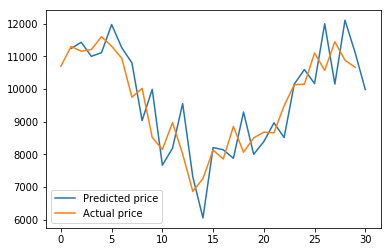

In [30]:
%matplotlib inline
plt.plot(range(1, len(predicted_price)+1), predicted_price, label='Predicted price')
plt.plot(range(len(predicted_price)), actuals, label='Actual price')
plt.legend()
_ = plt.ylim()

# Simulate returns for validation period
position = 0
cash = 1000
for ii in range(len(predicted_price)):
    action = ""
    if predicted_price[ii] > actuals[ii]:
        position += cash / actuals[ii] * 0.997 # 0.997 to account for fees
        cash = 0
        action = "BUY"
    
    if predicted_price[ii] < actuals[ii]:
        cash += position * actuals[ii] * 0.997
        position = 0
        action = "SELL"
        
    print("{} action. New position of {} BTC and ${}".format(action, position, cash))

## Prediction using LSTM

In [8]:
# Reshape data from (num_samples, features) to (num_samples, sequence_length, features)
sequence_length = 2

def seq_data(data_x, data_y, seq_length):
    seq_data_x = []
    seq_data_y = []
    for ii in range(len(data_x) - seq_length + 1):
        seq_data_x.append(data_x[ii : ii + seq_length])
        seq_data_y.append(data_y[ii + seq_length-1])
    return np.array(seq_data_x), np.array(seq_data_y)

train_x_seq, train_y_seq = seq_data(train_x, train_y, sequence_length)
valid_x_seq, valid_y_seq = seq_data(valid_x, valid_y, sequence_length)

In [9]:
class LSTM_net:
    """
    RNN using LSTM
    """
    def __init__(self, input_size, learning_rate):
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.build_model()

    def build_model(self):
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True,
                       input_shape=self.input_size))  # returns a sequence of vectors of dimension 32
        self.model.add(LSTM(64))  # return a single vector of dimension 32
        self.model.add(Dense(1, activation='linear'))

        # Define optimiser and compile
        optimizer = optimizers.Adam(self.learning_rate)
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

In [10]:
# Initialise weight saving callback
LSTM_checkpointer = ModelCheckpoint(filepath='./saved_models/LSTM_weights.hdf5',
                       verbose=1, save_best_only=True)

In [12]:
# Initialise training hyper parameters
learning_rate = 0.0001
input_size = (train_x_seq.shape[1], train_x_seq.shape[2])
epochs = 500
batch_size = 64

# Initialise neural network
LSTM_network = LSTM_net(input_size, learning_rate)

# Start training

LSTM_network.model.fit(train_x_seq, train_y_seq,
          batch_size=batch_size, epochs=epochs,
          callbacks=[LSTM_checkpointer],
          validation_data=(valid_x_seq, valid_y_seq))

Train on 639 samples, validate on 29 samples
Epoch 1/500
639/639 [==============================] - 2s 4ms/step - loss: 0.9277 - acc: 0.0000e+00 - val_loss: 2.7663 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 2.76633, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 2/500
639/639 [==============================] - 0s 155us/step - loss: 0.9177 - acc: 0.0000e+00 - val_loss: 2.7474 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 2.76633 to 2.74742, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 3/500
639/639 [==============================] - 0s 164us/step - loss: 0.9082 - acc: 0.0000e+00 - val_loss: 2.7298 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 2.74742 to 2.72977, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 4/500
639/639 [==============================] - 0s 159us/step - loss: 0.8992 - acc: 0.0000e+00 - val_loss: 2.7131 - val_acc: 0.0000e+00

Epoch 00004: val_loss improved from 2.72977 to 2.71305, saving model t

Epoch 34/500
639/639 [==============================] - 0s 152us/step - loss: 0.5424 - acc: 0.0000e+00 - val_loss: 1.8011 - val_acc: 0.0000e+00

Epoch 00034: val_loss improved from 1.84811 to 1.80108, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 35/500
639/639 [==============================] - 0s 147us/step - loss: 0.5239 - acc: 0.0000e+00 - val_loss: 1.7548 - val_acc: 0.0000e+00

Epoch 00035: val_loss improved from 1.80108 to 1.75479, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 36/500
639/639 [==============================] - 0s 150us/step - loss: 0.5058 - acc: 0.0000e+00 - val_loss: 1.7094 - val_acc: 0.0000e+00

Epoch 00036: val_loss improved from 1.75479 to 1.70944, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 37/500
639/639 [==============================] - 0s 143us/step - loss: 0.4878 - acc: 0.0000e+00 - val_loss: 1.6635 - val_acc: 0.0000e+00

Epoch 00037: val_loss improved from 1.70944 to 1.66351, saving model to ./saved_models/LSTM_weights.hdf5


Epoch 67/500
639/639 [==============================] - 0s 165us/step - loss: 0.2002 - acc: 0.0000e+00 - val_loss: 1.0911 - val_acc: 0.0000e+00

Epoch 00067: val_loss improved from 1.09618 to 1.09112, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 68/500
639/639 [==============================] - 0s 168us/step - loss: 0.1967 - acc: 0.0000e+00 - val_loss: 1.0898 - val_acc: 0.0000e+00

Epoch 00068: val_loss improved from 1.09112 to 1.08976, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 69/500
639/639 [==============================] - 0s 237us/step - loss: 0.1931 - acc: 0.0000e+00 - val_loss: 1.0878 - val_acc: 0.0000e+00

Epoch 00069: val_loss improved from 1.08976 to 1.08784, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 70/500
639/639 [==============================] - 0s 157us/step - loss: 0.1898 - acc: 0.0000e+00 - val_loss: 1.0861 - val_acc: 0.0000e+00

Epoch 00070: val_loss improved from 1.08784 to 1.08615, saving model to ./saved_models/LSTM_weights.hdf5


Epoch 100/500
639/639 [==============================] - 0s 214us/step - loss: 0.1176 - acc: 0.0000e+00 - val_loss: 1.0027 - val_acc: 0.0000e+00

Epoch 00100: val_loss did not improve
Epoch 101/500
639/639 [==============================] - 0s 199us/step - loss: 0.1159 - acc: 0.0000e+00 - val_loss: 0.9960 - val_acc: 0.0000e+00

Epoch 00101: val_loss improved from 1.00142 to 0.99600, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 102/500
639/639 [==============================] - 0s 186us/step - loss: 0.1142 - acc: 0.0000e+00 - val_loss: 0.9920 - val_acc: 0.0000e+00

Epoch 00102: val_loss improved from 0.99600 to 0.99199, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 103/500
639/639 [==============================] - 0s 178us/step - loss: 0.1125 - acc: 0.0000e+00 - val_loss: 0.9915 - val_acc: 0.0000e+00

Epoch 00103: val_loss improved from 0.99199 to 0.99155, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 104/500
639/639 [==============================] - 0s 184

639/639 [==============================] - 0s 210us/step - loss: 0.0729 - acc: 0.0000e+00 - val_loss: 0.9297 - val_acc: 0.0000e+00

Epoch 00134: val_loss improved from 0.93282 to 0.92965, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 135/500
639/639 [==============================] - 0s 225us/step - loss: 0.0722 - acc: 0.0000e+00 - val_loss: 0.9351 - val_acc: 0.0000e+00

Epoch 00135: val_loss did not improve
Epoch 136/500
639/639 [==============================] - 0s 190us/step - loss: 0.0710 - acc: 0.0000e+00 - val_loss: 0.9296 - val_acc: 0.0000e+00

Epoch 00136: val_loss improved from 0.92965 to 0.92955, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 137/500
639/639 [==============================] - ETA: 0s - loss: 0.0708 - acc: 0.0000e+0 - 0s 211us/step - loss: 0.0699 - acc: 0.0000e+00 - val_loss: 0.9290 - val_acc: 0.0000e+00

Epoch 00137: val_loss improved from 0.92955 to 0.92899, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 138/500
639/639 [============

639/639 [==============================] - 0s 201us/step - loss: 0.0443 - acc: 0.0000e+00 - val_loss: 0.8896 - val_acc: 0.0000e+00

Epoch 00171: val_loss did not improve
Epoch 172/500
639/639 [==============================] - 0s 194us/step - loss: 0.0436 - acc: 0.0000e+00 - val_loss: 0.8921 - val_acc: 0.0000e+00

Epoch 00172: val_loss did not improve
Epoch 173/500
639/639 [==============================] - 0s 173us/step - loss: 0.0431 - acc: 0.0000e+00 - val_loss: 0.8903 - val_acc: 0.0000e+00

Epoch 00173: val_loss did not improve
Epoch 174/500
639/639 [==============================] - 0s 165us/step - loss: 0.0426 - acc: 0.0000e+00 - val_loss: 0.8893 - val_acc: 0.0000e+00

Epoch 00174: val_loss did not improve
Epoch 175/500
639/639 [==============================] - 0s 164us/step - loss: 0.0420 - acc: 0.0000e+00 - val_loss: 0.8889 - val_acc: 0.0000e+00

Epoch 00175: val_loss improved from 0.88920 to 0.88889, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 176/500
639/639 [====

Epoch 210/500
639/639 [==============================] - 0s 214us/step - loss: 0.0273 - acc: 0.0000e+00 - val_loss: 0.8648 - val_acc: 0.0000e+00

Epoch 00210: val_loss improved from 0.86512 to 0.86484, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 211/500
639/639 [==============================] - 0s 236us/step - loss: 0.0271 - acc: 0.0000e+00 - val_loss: 0.8651 - val_acc: 0.0000e+00

Epoch 00211: val_loss did not improve
Epoch 212/500
639/639 [==============================] - 0s 196us/step - loss: 0.0268 - acc: 0.0000e+00 - val_loss: 0.8619 - val_acc: 0.0000e+00

Epoch 00212: val_loss improved from 0.86484 to 0.86192, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 213/500
639/639 [==============================] - 0s 254us/step - loss: 0.0264 - acc: 0.0000e+00 - val_loss: 0.8650 - val_acc: 0.0000e+00

Epoch 00213: val_loss did not improve
Epoch 214/500
639/639 [==============================] - 0s 240us/step - loss: 0.0262 - acc: 0.0000e+00 - val_loss: 0.8661 - val_a

639/639 [==============================] - 0s 192us/step - loss: 0.0180 - acc: 0.0000e+00 - val_loss: 0.8539 - val_acc: 0.0000e+00

Epoch 00250: val_loss did not improve
Epoch 251/500
639/639 [==============================] - 0s 240us/step - loss: 0.0178 - acc: 0.0000e+00 - val_loss: 0.8540 - val_acc: 0.0000e+00

Epoch 00251: val_loss did not improve
Epoch 252/500
639/639 [==============================] - 0s 247us/step - loss: 0.0176 - acc: 0.0000e+00 - val_loss: 0.8537 - val_acc: 0.0000e+00

Epoch 00252: val_loss did not improve
Epoch 253/500
639/639 [==============================] - 0s 250us/step - loss: 0.0175 - acc: 0.0000e+00 - val_loss: 0.8507 - val_acc: 0.0000e+00

Epoch 00253: val_loss did not improve
Epoch 254/500
639/639 [==============================] - 0s 186us/step - loss: 0.0172 - acc: 0.0000e+00 - val_loss: 0.8534 - val_acc: 0.0000e+00

Epoch 00254: val_loss did not improve
Epoch 255/500
639/639 [==============================] - 0s 183us/step - loss: 0.0171 - acc: 0

639/639 [==============================] - 0s 193us/step - loss: 0.0120 - acc: 0.0000e+00 - val_loss: 0.8548 - val_acc: 0.0000e+00

Epoch 00294: val_loss did not improve
Epoch 295/500
639/639 [==============================] - 0s 219us/step - loss: 0.0119 - acc: 0.0000e+00 - val_loss: 0.8524 - val_acc: 0.0000e+00

Epoch 00295: val_loss did not improve
Epoch 296/500
639/639 [==============================] - 0s 177us/step - loss: 0.0118 - acc: 0.0000e+00 - val_loss: 0.8534 - val_acc: 0.0000e+00

Epoch 00296: val_loss did not improve
Epoch 297/500
639/639 [==============================] - 0s 175us/step - loss: 0.0117 - acc: 0.0000e+00 - val_loss: 0.8532 - val_acc: 0.0000e+00

Epoch 00297: val_loss did not improve
Epoch 298/500
639/639 [==============================] - 0s 166us/step - loss: 0.0116 - acc: 0.0000e+00 - val_loss: 0.8533 - val_acc: 0.0000e+00

Epoch 00298: val_loss did not improve
Epoch 299/500
639/639 [==============================] - 0s 170us/step - loss: 0.0115 - acc: 0


Epoch 00338: val_loss did not improve
Epoch 339/500
639/639 [==============================] - 0s 190us/step - loss: 0.0083 - acc: 0.0000e+00 - val_loss: 0.8562 - val_acc: 0.0000e+00

Epoch 00339: val_loss did not improve
Epoch 340/500
639/639 [==============================] - 0s 223us/step - loss: 0.0083 - acc: 0.0000e+00 - val_loss: 0.8568 - val_acc: 0.0000e+00

Epoch 00340: val_loss did not improve
Epoch 341/500
639/639 [==============================] - 0s 228us/step - loss: 0.0082 - acc: 0.0000e+00 - val_loss: 0.8587 - val_acc: 0.0000e+00

Epoch 00341: val_loss did not improve
Epoch 342/500
639/639 [==============================] - 0s 242us/step - loss: 0.0082 - acc: 0.0000e+00 - val_loss: 0.8584 - val_acc: 0.0000e+00

Epoch 00342: val_loss did not improve
Epoch 343/500
639/639 [==============================] - 0s 234us/step - loss: 0.0081 - acc: 0.0000e+00 - val_loss: 0.8565 - val_acc: 0.0000e+00

Epoch 00343: val_loss did not improve
Epoch 344/500
639/639 [==================

639/639 [==============================] - 0s 187us/step - loss: 0.0061 - acc: 0.0000e+00 - val_loss: 0.8611 - val_acc: 0.0000e+00

Epoch 00383: val_loss did not improve
Epoch 384/500
639/639 [==============================] - 0s 188us/step - loss: 0.0061 - acc: 0.0000e+00 - val_loss: 0.8632 - val_acc: 0.0000e+00

Epoch 00384: val_loss did not improve
Epoch 385/500
639/639 [==============================] - 0s 185us/step - loss: 0.0060 - acc: 0.0000e+00 - val_loss: 0.8634 - val_acc: 0.0000e+00

Epoch 00385: val_loss did not improve
Epoch 386/500
639/639 [==============================] - 0s 226us/step - loss: 0.0060 - acc: 0.0000e+00 - val_loss: 0.8625 - val_acc: 0.0000e+00

Epoch 00386: val_loss did not improve
Epoch 387/500
639/639 [==============================] - 0s 218us/step - loss: 0.0060 - acc: 0.0000e+00 - val_loss: 0.8635 - val_acc: 0.0000e+00

Epoch 00387: val_loss did not improve
Epoch 388/500
639/639 [==============================] - 0s 174us/step - loss: 0.0060 - acc: 0

639/639 [==============================] - 0s 189us/step - loss: 0.0049 - acc: 0.0000e+00 - val_loss: 0.8683 - val_acc: 0.0000e+00

Epoch 00427: val_loss did not improve
Epoch 428/500
639/639 [==============================] - 0s 206us/step - loss: 0.0048 - acc: 0.0000e+00 - val_loss: 0.8680 - val_acc: 0.0000e+00

Epoch 00428: val_loss did not improve
Epoch 429/500
639/639 [==============================] - 0s 204us/step - loss: 0.0048 - acc: 0.0000e+00 - val_loss: 0.8679 - val_acc: 0.0000e+00

Epoch 00429: val_loss did not improve
Epoch 430/500
639/639 [==============================] - 0s 176us/step - loss: 0.0048 - acc: 0.0000e+00 - val_loss: 0.8683 - val_acc: 0.0000e+00

Epoch 00430: val_loss did not improve
Epoch 431/500
639/639 [==============================] - 0s 193us/step - loss: 0.0048 - acc: 0.0000e+00 - val_loss: 0.8695 - val_acc: 0.0000e+00

Epoch 00431: val_loss did not improve
Epoch 432/500
639/639 [==============================] - 0s 197us/step - loss: 0.0047 - acc: 0

639/639 [==============================] - 0s 202us/step - loss: 0.0040 - acc: 0.0000e+00 - val_loss: 0.8712 - val_acc: 0.0000e+00

Epoch 00471: val_loss did not improve
Epoch 472/500
639/639 [==============================] - 0s 212us/step - loss: 0.0040 - acc: 0.0000e+00 - val_loss: 0.8743 - val_acc: 0.0000e+00

Epoch 00472: val_loss did not improve
Epoch 473/500
639/639 [==============================] - 0s 198us/step - loss: 0.0040 - acc: 0.0000e+00 - val_loss: 0.8725 - val_acc: 0.0000e+00

Epoch 00473: val_loss did not improve
Epoch 474/500
639/639 [==============================] - 0s 197us/step - loss: 0.0040 - acc: 0.0000e+00 - val_loss: 0.8738 - val_acc: 0.0000e+00

Epoch 00474: val_loss did not improve
Epoch 475/500
639/639 [==============================] - 0s 202us/step - loss: 0.0040 - acc: 0.0000e+00 - val_loss: 0.8744 - val_acc: 0.0000e+00

Epoch 00475: val_loss did not improve
Epoch 476/500
639/639 [==============================] - 0s 162us/step - loss: 0.0040 - acc: 0

In [18]:
# Load the model weights with the best validation loss.
LSTM_network.model.load_weights('saved_models/LSTM_weights.hdf5')

prediction = []
for ii in range(len(valid_x_seq)):
    input_data = np.reshape(valid_x_seq[ii], (-1, valid_x_seq.shape[1], valid_x_seq.shape[2]))
    model_output = LSTM_network.model.predict(input_data)
    prediction.append(model_output.item() * y_std + y_mean)
    
predicted_price = ([x + 1 for x in prediction]) * actuals[1:]

Day 0: BUY. Price expected to change from 10699.7 to 11789.2993473908. Portfolio value of 997.0
Day 1: SELL. Price expected to change from 11303.0 to 10917.57051181817. Portfolio value of 1050.0559573632906
Day 2: BUY. Price expected to change from 11156.1 to 11205.71780462046. Portfolio value of 1046.9057894912007
Day 3: BUY. Price expected to change from 11206.8 to 11937.584339724754. Portfolio value of 1051.663556410393
Day 4: SELL. Price expected to change from 11600.0 to 11295.031967279734. Portfolio value of 1085.2963702928116
Day 5: SELL. Price expected to change from 11309.7 to 10838.75819345148. Portfolio value of 1085.2963702928116
Day 6: SELL. Price expected to change from 10939.1 to 8894.606115861854. Portfolio value of 1085.2963702928116
Day 7: BUY. Price expected to change from 9750.1 to 10023.672760344787. Portfolio value of 1082.040481181933
Day 8: SELL. Price expected to change from 10020.3 to 7430.540559906135. Portfolio value of 1108.6904875731082
Day 9: SELL. Price 

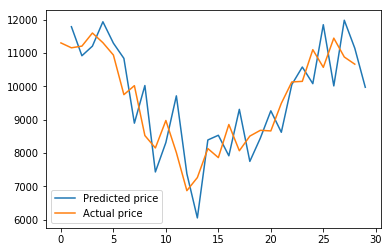

In [22]:
%matplotlib inline
plt.plot(range(1, len(predicted_price)+1), predicted_price, label='Predicted price')
plt.plot(range(len(predicted_price)), actuals[1:], label='Actual price')
plt.legend()
_ = plt.ylim()

# Simulate returns for validation period
position = 0
cash = 1000
for ii in range(len(predicted_price)):
    action = ""
    if predicted_price[ii] > actuals[ii]:
        position += cash / actuals[ii] * 0.997 # 0.997 to account for fees
        cash = 0
        action = "BUY"
    
    if predicted_price[ii] < actuals[ii]:
        cash += position * actuals[ii] * 0.997
        position = 0
        action = "SELL"
        
    print("Day {}: {}. Price expected to change from {} to {}. Portfolio value of {}".format(ii, action, actuals[ii], predicted_price[ii], position*actuals[ii] + cash))